In [1]:
import os
os.chdir('../')


In [2]:
import torch

import matplotlib.pyplot as pyplot
import argparse
from dataset import make_loader
from models import methods, resnet
from models.methods import BaseMethod
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
METHOD_NAMES = [name for name in methods.__all__
                if not name.startswith('__') and callable(methods.__dict__[name])]
BACKBONE_NAMES = sorted(name for name in resnet.__all__
                        if name.islower() and not name.startswith("__")
                        and callable(resnet.__dict__[name]))
print(f"{METHOD_NAMES}")
print(f"{BACKBONE_NAMES}")

['BaseMethod', 'SD_Dropout', 'CS_KD', 'DDGSD', 'CS_KD_Dropout', 'DDGSD_Dropout', 'BYOT', 'BYOT_Dropout', 'DML', 'DML_Dropout', 'DML_Dropout_V1']
['byot_resnet18', 'byot_resnet18_cifar', 'resnet101', 'resnet152', 'resnet18', 'resnet18_cifar', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext50_32x4d', 'wide_resnet101_2', 'wide_resnet50_2']


In [4]:
# dml byot 
class Args():
    num_workers = 1
    beta = 0
    aug = True
    batch_size = 128
    dataset = 'CIFAR100'
    method = 'BYOT'
    backbone = 'byot_resnet18_cifar'
    # byot baseline
    path_base = "saved_models/CIFAR100_BYOT_Dropout_byot_resnet18_cifar__p0.5_t3.0_alpha0.0_beta0.1_B128_seed41_detachFalse/checkpoint_last.pth.tar"
    # byot with self dropout
    path_drop = "saved_models/CIFAR100_BYOT_Dropout_byot_resnet18_cifar__p0.5_t3.0_alpha0.1_beta0.1_B128_seed41_detachFalse/checkpoint_last.pth.tar"

    
args = Args()


In [5]:
trainloader, testloader = make_loader(args.dataset, batch_size=args.batch_size, aug=args.aug, num_workers=args.num_workers)


Files already downloaded and verified
Files already downloaded and verified


In [43]:

############### Define Model ###############

## construct the model
num_classes = {'CIFAR10': 10, 'CIFAR100':100, 'CUB200':200, 'DOG':120}

# baseline
backbone = resnet.__dict__[args.backbone](num_classes=num_classes[args.dataset])
state_dict = torch.load(args.path_base)
model = methods.__dict__[args.method](args, backbone)
model.load_state_dict(state_dict['state_dict'])
model.cuda()

# baseline + self dropout
backbone = resnet.__dict__[args.backbone](num_classes=num_classes[args.dataset])
state_dict_drop = torch.load(args.path_drop)
model_drop = methods.__dict__[args.method](args, backbone)
model_drop.load_state_dict(state_dict_drop['state_dict'])
model_drop.cuda()

print('model load complete')
        


init neural networks
model load complete


In [44]:
model.eval()
pred = []
pred_drop = []
Y = []

with torch.no_grad():
    for x, y in tqdm(testloader):
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

            outputs = model(x)
            pred.append(torch.softmax(outputs, dim=0).detach().cpu().numpy())
            Y.append(y.detach().cpu().numpy())


            outputs_drop = model_drop(x)
            pred_drop.append(torch.softmax(outputs_drop, dim=0).detach().cpu().numpy())



100%|██████████| 79/79 [00:02<00:00, 31.96it/s]


In [45]:
Y = np.concatenate(Y)
pred = np.concatenate(pred)
pred_drop = np.concatenate(pred_drop)

acc = (np.argmax(pred, axis=1) == Y)
confidence = np.max(pred,axis=1)

acc_drop = (np.argmax(pred_drop, axis=1) == Y)
confidence_drop = np.max(pred_drop,axis=1)




In [46]:
import pandas as pd

df = pd.DataFrame({'acc':acc, 'confidence':confidence})
df['confidence_bin'] = df['confidence'].map(lambda x : round(x*10)/10)
df['acc'] = df['acc'].map(lambda x : 1 if x else 0)
df.drop(columns=['confidence'], inplace=True)
df


df_drop = pd.DataFrame({'acc':acc_drop, 'confidence':confidence_drop})
df_drop['confidence_bin'] = df_drop['confidence'].map(lambda x : round(x*10)/10)
df_drop['acc'] = df_drop['acc'].map(lambda x : 1 if x else 0)
df_drop.drop(columns=['confidence'], inplace=True)
df_drop




,acc,confidence_bin
0,0,0.2
1,1,0.0
2,0,0.9
3,1,1.0
4,1,0.6
...,...,...
9995,0,1.0
9996,0,0.8
9997,1,1.0
9998,1,1.0


In [48]:
df_ = df.groupby('confidence_bin').mean()
df_drop_ = df_drop.groupby('confidence_bin').mean()
df_


,acc
confidence_bin,
0.0,0.172258
0.1,0.303571
0.2,0.402235
0.3,0.447500
0.4,0.429907
0.5,0.468750
0.6,0.525316
0.7,0.568047
0.8,0.620419


In [49]:
df_['acc_drop'] = df_drop_['acc']
df_

,acc,acc_drop
confidence_bin,,
0.0,0.172258,0.161880
0.1,0.303571,0.385743
0.2,0.402235,0.538095
0.3,0.447500,0.656051
0.4,0.429907,0.681435
0.5,0.468750,0.715746
0.6,0.525316,0.721461
0.7,0.568047,0.737634
0.8,0.620419,0.809426


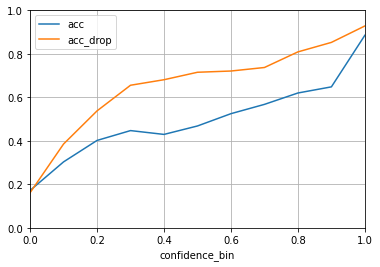

In [54]:
plt = df_.plot(xlim=[0,1], ylim=[0,1])
plt.grid()
